<a href="https://colab.research.google.com/github/alex-smith-uwec/AI_Spring2025/blob/main/FrozenLake_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt


In [2]:

# Initialize FrozenLake environment
env = gym.make("FrozenLake-v1", desc=None, map_name="4x4", is_slippery=True, render_mode=None)
n_actions = env.action_space.n
n_states = env.observation_space.n


In [3]:
def print_frozen_lake_layout(env):
    desc = env.unwrapped.desc.astype(str)
    size = desc.shape[0]

    for i in range(size):
        row = ""
        for j in range(size):
            cell = f" {desc[i][j]} "
            row += f"|{cell}"
        row += "|"
        print(row)
        print("-" * len(row))
print_frozen_lake_layout(env)

| S | F | F | F |
-----------------
| F | H | F | H |
-----------------
| F | F | F | H |
-----------------
| H | F | F | G |
-----------------


In [4]:
# Q-learning parameters
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 1.0  # Initial exploration probability
epsilon_min = 0.01
epsilon_decay = 0.999
num_episodes = 5000


In [5]:

# Initialize Q-table
Q = np.zeros((n_states, n_actions))

# Store rewards per episode
rewards_per_episode = []

# Q-learning loop
for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        # Choose action using epsilon-greedy policy
        if np.random.rand() < epsilon:
            action = env.action_space.sample()  # Explore
        else:
            action = np.argmax(Q[state, :])  # Exploit

        next_state, reward, done, truncated, _ = env.step(action)

        # Update Q-value
        Q[state, action] = (1 - alpha) * Q[state, action] + alpha * (reward + gamma * np.max(Q[next_state, :]))

        state = next_state
        total_reward += reward

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards_per_episode.append(total_reward)

    if (episode + 1) % 500 == 0:
        print(f"Episode {episode + 1}/{num_episodes}, Epsilon: {epsilon:.4f}, Avg Reward: {np.mean(rewards_per_episode[-100:]):.2f}")


Episode 500/5000, Epsilon: 0.6064, Avg Reward: 0.06
Episode 1000/5000, Epsilon: 0.3677, Avg Reward: 0.10
Episode 1500/5000, Epsilon: 0.2230, Avg Reward: 0.15
Episode 2000/5000, Epsilon: 0.1352, Avg Reward: 0.38
Episode 2500/5000, Epsilon: 0.0820, Avg Reward: 0.47
Episode 3000/5000, Epsilon: 0.0497, Avg Reward: 0.49
Episode 3500/5000, Epsilon: 0.0301, Avg Reward: 0.46
Episode 4000/5000, Epsilon: 0.0183, Avg Reward: 0.58
Episode 4500/5000, Epsilon: 0.0111, Avg Reward: 0.79
Episode 5000/5000, Epsilon: 0.0100, Avg Reward: 0.67


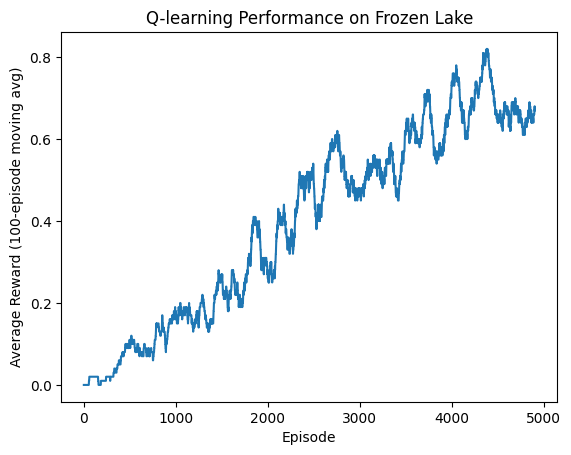

Learned Q-table:
[[0.5090654  0.46706836 0.46944487 0.47079084]
 [0.34098105 0.28792072 0.3076458  0.3983864 ]
 [0.27832338 0.24871924 0.2642739  0.26078832]
 [0.02843059 0.15052117 0.01863612 0.10309891]
 [0.52898093 0.33899355 0.33523982 0.26941132]
 [0.         0.         0.         0.        ]
 [0.13988648 0.13718318 0.2244309  0.09542485]
 [0.         0.         0.         0.        ]
 [0.36626234 0.3307123  0.31004559 0.56931033]
 [0.35421474 0.61917242 0.44894385 0.46564762]
 [0.61013529 0.36198702 0.22708629 0.31717428]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.41461301 0.57511796 0.70915749 0.5763578 ]
 [0.67804072 0.8983164  0.69395377 0.73901492]
 [0.         0.         0.         0.        ]]



Optimal state values from Value Iteration:
[0.54201404 0.49878743 0.47067727 0.45683193 0.5584404  0.
 0.35834012 0.         0.59179013 0.64307363 0.61520214 0.
 0.         0.74171617 0.86283528 0.        ]
State | Max Q-Value 

In [6]:
# Plot learning curve
plt.plot(np.convolve(rewards_per_episode, np.ones(100)/100, mode='valid'))
plt.xlabel("Episode")
plt.ylabel("Average Reward (100-episode moving avg)")
plt.title("Q-learning Performance on Frozen Lake")
plt.show()

# Display learned Q-table
print("Learned Q-table:")
print(Q)

# Value Iteration to find optimal utilities
V = np.zeros(n_states)
threshold = 1e-6
delta = float("inf")
env_unwrapped = env.unwrapped  # Get the raw environment

while delta > threshold:
    delta = 0
    for state in range(n_states):
        v = V[state]
        V[state] = max(sum(prob * (reward + gamma * V[next_state])
                          for prob, next_state, reward, _ in env_unwrapped.P[state][action])
                       for action in range(n_actions))
        delta = max(delta, abs(v - V[state]))

# Display optimal utility values
print("\n\n\nOptimal state values from Value Iteration:")
print(V)

# Compare max Q-values to optimal state values
print("State | Max Q-Value | Optimal V-Value | Difference")
print("---------------------------------------------------")
for state in range(n_states):
    max_q = np.max(Q[state, :])
    optimal_v = V[state]
    diff = abs(max_q - optimal_v)
    print(f"{state:5} | {max_q:10.4f} | {optimal_v:10.4f} | {diff:10.4f}")


In [8]:
# Extract  policy from Q-table
policy_Q = np.argmax(Q, axis=1)

# Convert to grid shape for FrozenLake (4×4)
policy_grid = policy_Q.reshape(env.unwrapped.desc.shape)

# Map action indices to arrow symbols for readability
action_map = {0: '←', 1: '↓', 2: '→', 3: '↑'}
policy_symbols = np.vectorize(action_map.get)(policy_grid)

print("Extracted Q-Learning Policy (←, ↓, →, ↑):")
for row in policy_symbols:
    print(' '.join(row))

print(policy_Q)

Extracted Q-Learning Policy (←, ↓, →, ↑):
← ↑ ← ↓
← ← → ←
↑ ↓ ← ←
← → ↓ ←
[0 3 0 1 0 0 2 0 3 1 0 0 0 2 1 0]



Average reward per episode using the optimal policy: 0.7940
Average number of steps per episode: 45.41


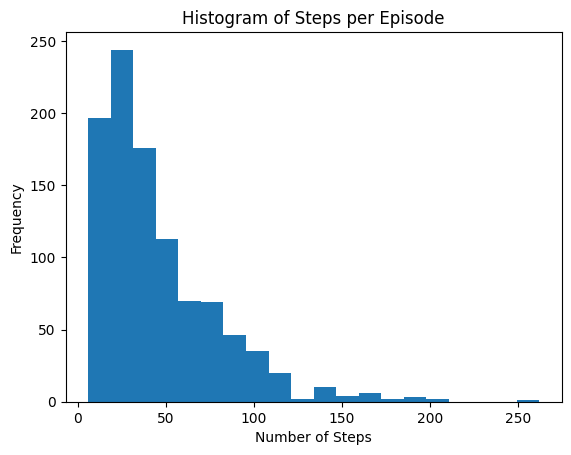

In [10]:
# Simulate average reward per episode using the optimal policy
# In the simulation of average reward, keep track of the number of steps per episode, and make a histogram of the number of steps.

num_simulations = 1000
total_rewards = []
steps_per_episode = []  # Keep track of steps per episode

for _ in range(num_simulations):
    state, _ = env.reset()
    total_reward = 0
    done = False
    steps = 0

    while not done:
        action = policy_Q[state]  # Use the extracted policy
        next_state, reward, done, truncated, _ = env.step(action)
        state = next_state
        total_reward += reward
        steps += 1

    total_rewards.append(total_reward)
    steps_per_episode.append(steps)

average_reward = np.mean(total_rewards)
average_steps = np.mean(steps_per_episode)  # Calculate average steps
print(f"\nAverage reward per episode using the optimal policy: {average_reward:.4f}")
print(f"Average number of steps per episode: {average_steps:.2f}")

# Histogram of number of steps per episode
plt.hist(steps_per_episode, bins=20)
plt.xlabel("Number of Steps")
plt.ylabel("Frequency")
plt.title("Histogram of Steps per Episode")
plt.show()


In [11]:
# Q-learning parameters
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 1.0  # Initial exploration probability
epsilon_min = 0.01
epsilon_decay = 0.999
num_episodes = 5000

In [12]:
# Initialize Q-table
Q = np.zeros((n_states, n_actions))
rewards_per_episode = []

for episode in range(num_episodes):
    state, _ = env.reset()
    # Initial action via epsilon-greedy
    if np.random.rand() < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(Q[state, :])

    total_reward = 0
    done = False

    while not done:
        next_state, reward, done, truncated, _ = env.step(action)
        # Choose next action via epsilon-greedy
        if np.random.rand() < epsilon:
            next_action = env.action_space.sample()
        else:
            next_action = np.argmax(Q[next_state, :])

        # SARSA update
        Q[state, action] = (1 - alpha) * Q[state, action] + alpha * (
            reward + gamma * Q[next_state, next_action]
        )

        state, action = next_state, next_action
        total_reward += reward

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards_per_episode.append(total_reward)

    if (episode + 1) % 500 == 0:
        print(f"Episode {episode + 1}/{num_episodes}, Epsilon: {epsilon:.4f}, "
              f"Avg Reward: {np.mean(rewards_per_episode[-100:]):.2f}")


Episode 500/5000, Epsilon: 0.6064, Avg Reward: 0.02
Episode 1000/5000, Epsilon: 0.3677, Avg Reward: 0.10
Episode 1500/5000, Epsilon: 0.2230, Avg Reward: 0.15
Episode 2000/5000, Epsilon: 0.1352, Avg Reward: 0.30
Episode 2500/5000, Epsilon: 0.0820, Avg Reward: 0.43
Episode 3000/5000, Epsilon: 0.0497, Avg Reward: 0.48
Episode 3500/5000, Epsilon: 0.0301, Avg Reward: 0.67
Episode 4000/5000, Epsilon: 0.0183, Avg Reward: 0.65
Episode 4500/5000, Epsilon: 0.0111, Avg Reward: 0.62
Episode 5000/5000, Epsilon: 0.0100, Avg Reward: 0.74


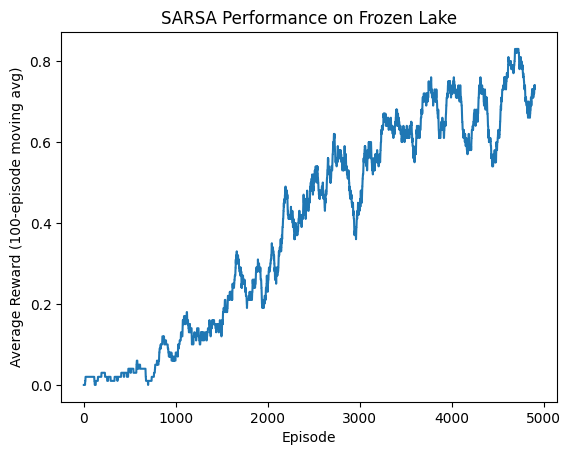

Learned SARSA Q-table:
[[0.53387992 0.46611022 0.463188   0.46471795]
 [0.20756582 0.17783354 0.14897734 0.40780339]
 [0.35513313 0.17639088 0.19379597 0.19164256]
 [0.11230045 0.00990634 0.00317155 0.04399392]
 [0.5602736  0.31594591 0.34970807 0.2570077 ]
 [0.         0.         0.         0.        ]
 [0.1400986  0.04925292 0.29155635 0.05094065]
 [0.         0.         0.         0.        ]
 [0.43956036 0.41007913 0.31480699 0.60760337]
 [0.46968989 0.64664297 0.43912246 0.39082473]
 [0.57516434 0.21386322 0.37283892 0.25009511]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.52283538 0.5745791  0.75478672 0.41038085]
 [0.6576712  0.87323569 0.74629528 0.69476655]
 [0.         0.         0.         0.        ]]


Optimal state values from Value Iteration:
[0.54201404 0.49878743 0.47067727 0.45683193 0.5584404  0.
 0.35834012 0.         0.59179013 0.64307363 0.61520214 0.
 0.         0.74171617 0.86283528 0.        ]
State | Max Q-V

In [13]:
# Plot SARSA learning curve
plt.plot(np.convolve(rewards_per_episode, np.ones(100)/100, mode='valid'))
plt.xlabel("Episode")
plt.ylabel("Average Reward (100‑episode moving avg)")
plt.title("SARSA Performance on Frozen Lake")
plt.show()

# Display learned SARSA Q-table
print("Learned SARSA Q-table:")
print(Q)

# Value Iteration to find optimal utilities
V = np.zeros(n_states)
threshold = 1e-6
delta = float("inf")
env_unwrapped = env.unwrapped

while delta > threshold:
    delta = 0
    for state in range(n_states):
        v = V[state]
        V[state] = max(
            sum(prob * (reward + gamma * V[next_state])
                for prob, next_state, reward, _ in env_unwrapped.P[state][action])
            for action in range(n_actions)
        )
        delta = max(delta, abs(v - V[state]))

print("\n\nOptimal state values from Value Iteration:")
print(V)

# Compare SARSA max Q-values to optimal state values
print("State | Max Q-Value | Optimal V-Value | Difference")
print("---------------------------------------------------")
for state in range(n_states):
    max_q = np.max(Q[state, :])
    optimal_v = V[state]
    diff = abs(max_q - optimal_v)
    print(f"{state:5} | {max_q:10.4f} | {optimal_v:10.4f} | {diff:10.4f}")


In [14]:
# Extract SARSA policy from Q-table
policy_sarsa = np.argmax(Q, axis=1)

# Convert to grid shape for FrozenLake (4×4)
policy_grid = policy_sarsa.reshape(env.unwrapped.desc.shape)

# Map action indices to arrow symbols for readability
action_map = {0: '←', 1: '↓', 2: '→', 3: '↑'}
policy_symbols = np.vectorize(action_map.get)(policy_grid)

print("Extracted SARSA Policy (←, ↓, →, ↑):")
for row in policy_symbols:
    print(' '.join(row))

print(policy_Q)
print(policy_sarsa)

Extracted SARSA Policy (←, ↓, →, ↑):
← ↑ ← ←
← ← → ←
↑ ↓ ← ←
← → ↓ ←
[0 3 0 1 0 0 2 0 3 1 0 0 0 2 1 0]
[0 3 0 0 0 0 2 0 3 1 0 0 0 2 1 0]
